In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Specify the directory containing your images
directory = 'tomato'

# Load the dataset
dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',  # Assuming binary classification between healthy and unhealthy
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),  # Adjust the image size as needed
    shuffle=True,
    seed=123,  # For reproducibility
    validation_split=0.2,  # 20% of data used for validation
    subset='training',  # Specify 'training' for training set
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    data_format=None,
)

# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',  # Specify 'validation' for validation set
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    data_format=None,
)

# Preprocess the images to maintain aspect ratio if necessary
def resize_and_pad(image, label):
    image = tf.image.resize_with_pad(image, 256, 256)
    return image, label

dataset = dataset.map(resize_and_pad)
validation_dataset = validation_dataset.map(resize_and_pad)

# Now you can iterate through the dataset to access your images and labels
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)
for images, labels in validation_dataset.take(1):
    print(images.shape, labels.shape)


Found 3500 files belonging to 2 classes.
Using 2800 files for training.
Found 3500 files belonging to 2 classes.
Using 700 files for validation.
(32, 256, 256, 3) (32, 1)
(32, 256, 256, 3) (32, 1)


2024-05-27 23:20:12.277082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-27 23:20:12.425513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import numpy as np

# Specify the directory containing your images
directory = 'tomato'

# Load the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',  # Use 'int' for categorical labels
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False
)

# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False
)

# Preprocess the images to maintain aspect ratio if necessary
def resize_and_pad(image, label):
    image = tf.image.resize_with_pad(image, 256, 256)
    return image, label

train_dataset = train_dataset.map(resize_and_pad)
validation_dataset = validation_dataset.map(resize_and_pad)

# Normalize images to the [0, 1] range
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Define the model
num_classes = 2  # Binary classification

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])




Found 3500 files belonging to 2 classes.
Using 2800 files for training.
Found 3500 files belonging to 2 classes.
Using 700 files for validation.


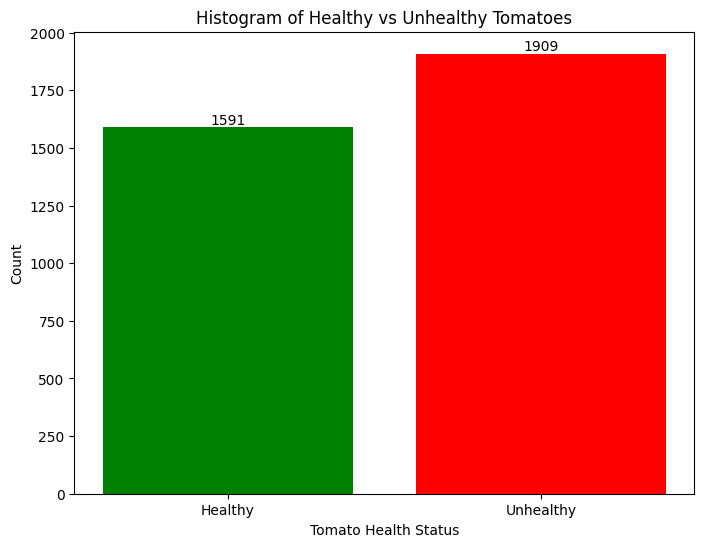

In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the parent directory
parent_dir = 'tomato'

# Initialize counters
healthy_count = 0
unhealthy_count = 0

# Directly access the 'healthy' and 'unhealthy' folders
healthy_folder = os.path.join(parent_dir, 'healthy')
unhealthy_folder = os.path.join(parent_dir, 'unhealthy')

# Count files in the 'healthy' folder
if os.path.exists(healthy_folder):
    healthy_count = len([item for item in os.listdir(healthy_folder) if os.path.isfile(os.path.join(healthy_folder, item))])

# Count files in the 'unhealthy' folder
if os.path.exists(unhealthy_folder):
    unhealthy_count = len([item for item in os.listdir(unhealthy_folder) if os.path.isfile(os.path.join(unhealthy_folder, item))])

# Prepare data for plotting
labels = ['Healthy', 'Unhealthy']
values = [healthy_count, unhealthy_count]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, values, color=['green', 'red'])

# Adding numbers on top of each bar
for i, v in enumerate(values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.xlabel('Tomato Health Status')
plt.ylabel('Count')
plt.title('Histogram of Healthy vs Unhealthy Tomatoes')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()


In [ ]:
model.summary()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10  # Set the number of epochs as needed
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

# Evaluate the model
score = model.evaluate(validation_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Save the model
model.save('model.keras')

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os

# Load the trained model
model = tf.keras.models.load_model('model.keras')

# Specify the directory containing your new images
new_images_directory = 'new_tomato_images'

# Load the new images dataset
new_images_dataset = image_dataset_from_directory(
    new_images_directory,
    labels=None,  # No labels for new images
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),  # Ensure this matches the input size used during training
    shuffle=False
)

# Preprocess the images (resize and normalize)
def preprocess_image(image):
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.cast(image, tf.float32) / 255.0
    return image

new_images_dataset = new_images_dataset.map(preprocess_image)

predictions = model.predict(new_images_dataset)

predicted_classes = np.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes)




Found 7 files.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Predicted classes: [0 0 0 0 0 0 0]


In [24]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


In [25]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()




In [26]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
img_path = "new_tomato_images/0a3f65fc-ef1c-4aed-b235-46bae4e5c0e7___GHLB2 Leaf 9065.JPG"
last_conv_layer_name = "block14_sepconv2_act"
img_size = (256, 256)

FileNotFoundError: [Errno 2] No such file or directory: 'new_tomato_images/0a3f65fc-ef1c-4aed-b235-46bae4e5c0e7___GHLB2 Leaf 9065.JPG'

In [28]:
model = tf.keras.models.load_model('model.keras')

In [29]:
import numpy as np

# Generate predictions
y_pred_probs = model.predict(validation_dataset)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Assuming your validation_dataset provides true labels in its second element
y_true_labels = next(iter(validation_dataset))[1]



2024-05-27 23:21:09.143188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step


In [32]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

y_pred_probs = model.predict(validation_dataset)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Correctly aggregate true labels across all batches
true_labels_all = []
for images, labels in validation_dataset:
    true_labels_all.extend(labels.numpy())
y_true_labels = np.array(true_labels_all)

# Calculate metrics
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step
Precision: 0.9832128106624668
Recall: 0.9828571428571429
F1 Score: 0.9828316840085429


2024-05-27 23:23:40.178013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


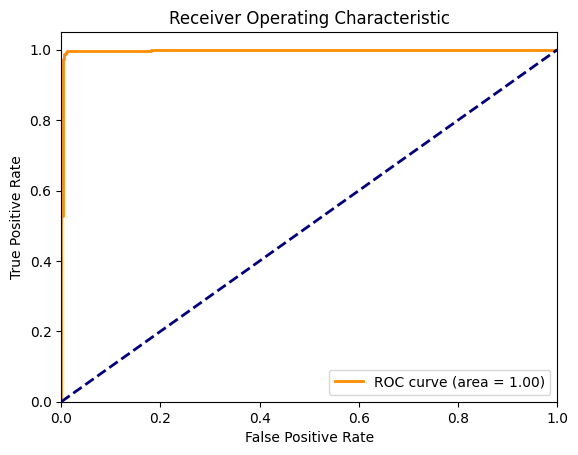

In [41]:
#Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


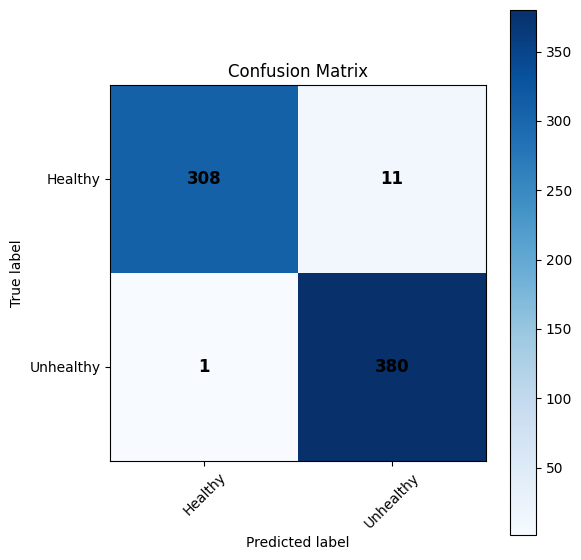

In [40]:
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)


num_classes = len(conf_matrix)  # Number of classes

fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size as needed
cmap = plt.cm.Blues
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)

# Adding title and colorbar
ax.set_title('Confusion Matrix')
fig.colorbar(im, ax=ax)

# Adding tick marks and labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, ['Healthy', 'Unhealthy'], rotation=45)
plt.yticks(tick_marks, ['Healthy', 'Unhealthy'])

# Function to draw text in each cell
def draw_text(ax, mat, min_val, max_val, num_classes):
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, mat[i, j],
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if mat[i, j] < 0 else "black",
                    fontsize=12,
                    fontweight=600)

draw_text(ax, conf_matrix, 0, max(conf_matrix.flatten()), num_classes)

# Setting labels
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.tight_layout()
plt.show()

